# Particle Filters in Julia

This work was done by Katie Li, as part of her Undergraduate Summer Research Assistant position under my supervision, between May and August 2017. 

## Particle Filters

### Overview*

The process of filtering refers to a Bayesian methodology for computing posterior distributions of dynamic system states based on a history of noisy measurements. The particle filter is a statistical, computational approach to estimating posterior distributions of states of *non-linear* and *non-Gaussian* state-space systems that would otherwise be difficult for the Kalman filter.



## Background

### Hidden Markov Model

A Hidden Markov Model (HMM) is a tool for representing probability distributions over sequences of observations. In HMMs, a sequence of observations ${y_1, ..., y_t}$ is modeled by assuming that at each time step, $y_t$ was generated from a hidden state variable $x_t$. 

The states of the hidden process, $x_1, ..., x_t$ satisfy the Markov property, in that given the value of $x_{t-1}$, the state $x_t$ is independent of all states prior to $t-1$. An additional assumption is that the observations/measurements $y_t$ also satisfy a Markov property with respect to the states, so that given $x_t$, $y_t$ is independent of $y_{t-1},..., y_1$

$$P(x_t | x_{1: t-1}) = P(x_t |x_{t-1})$$
$$P(y_t | x_{1: t-1}, y_{1:t-1}) = P(y_t|x_t)$$

The relationship between states $x_t$ and measurements $y_t$ is shown in the following figure:
<img src="FG_HMM.png" width="300">


#### System Equations

The system can be described by the equations

$$x_{t+1} = f_t(x_t, w_t) $$

$$y_t = h_t(x_t, v_t)$$

where the subscript $t = 1, 2, …,$ denotes a time instant in a dynamic problem. 

The states $x_1, x_2, ...$ advance in accordance with the state evolution model given by the above equation for $x_{t+1}$. The state/process noise, denoted by $w_t$, has known pdf $w_t \sim N(0, Q)$. The function $f_t$ is, in the general case, a non-linear function of the states and process noise.

The measurements or observations $y_1, y_2, ...,$ are related to the states through the possibly non-linear function $h_t$. The measurement noise, denoted by $v_t$, also has known pdf $v_t \sim N(0, R)$. We assume that $w_t$ and $v_t$ are independent.


#### Recursive Bayesian Filtering in Hidden Markov Models

Bayesian filtering uses Bayes Theorem to recursively estimate an unknown state $x_k$ of a system over time using a sequence of incoming measurements $y_k$, $k = 0, 1, ...$. The objective is to approximate the conditional pdf of $x_k$, or $p(x_k | y_{1:k})$.

Recursive filtering consists of two stages: prediction and update.
* We assume that the initial pdf $p(x_0|y_0) = p(x_0)$ is known.

* The prediction step uses the system model to predict the state pdf forward from one measurement time to the next. Therefore the prediction pdf is $p(x_k|y_{1:k-1})$, which represents the *apriori* estimate of $x_k$

    Since states $x_k$ satisfy the Markov property, we use the fact that $p(x_k|x_{k-1}, y_{1:k-1}) = p(x_k|x_{k-1})$ to derive the prediction pdf:

$$p(x_k|y_{1:k-1}) = \int p(x_k|x_{k-1})p(x_{k-1}|y_{1:k-1})$$

* The update step uses the latest measurement to modify the prediction pdf using Bayes theorem. The updated pdf is $p(x_k|y_{1:k})$, which represents the *aposteriori* estimate of $x_k$.

$$p(x_k|y_{1:k}) = p(y_k|x_k)p(x_k|y_{1:k-1})/p(y_k|y_{1:k-1})$$

Analytical solutions to these equations are rarely available. If $f_k$ and $h_k$ are linear functions with respect to $x_k$ and the white noise processes are additive, then we can solve for $p(x_t | y_t)$ using the ***Kalman Filter***. However, if the system is non-linear or the noises are non-Gaussian, closed-form solutions do not exist. Instead, we can use the ***Particle Filter***, a Monte Carlo method that approximates the posterior density $p(x_t | y_t)$ in terms of random samples (particles) and associated weights. As the number of particles $N$ increases toward $\infty$, this converges to the actual distribution.

***


#### Particle Filter Example and Implementation

In this example, we will use the following process and measurement equations:

$$x_k = \frac{1}{2}x_{k-1}  + \frac{25x_{k-1}}{(1+x_{k-1})^2} + 8\cos(1.2(k-1)) + w_k$$

$$y_k = \frac{x_k^2}{20} + v_k$$

where $w_k$ and $v_k$ are independent white noise variables, both with $\sigma = 1$


Let's begin by initializing the process and measurement functions:

In [1]:
using Distributions

function f_t(x_pre, k)
    return (1/2)*x_pre + (25*x_pre)/(1+x_pre^2) + 8*cos(1.2*(k-1))
end

#process equation
function x_t(f_t, x_pre, k, Q = 1)
    return f_t.(x_pre, k) + rand(Normal(0,Q), length(x_pre))
end

function h_t(x_cur)
    return (1/20)*x_cur^2
end

#observation equation
function y_t(h_t, x_cur, R = 1)
    return h_t.(x_cur) + rand(Normal(0, R), length(x_cur))
end


y_t (generic function with 2 methods)

The function *x_t* generates a sample from $p(x_t|x_{t-1} = x_{pre})$ while the function $y_t$ generates a sample from $p(y_t|x_t = x_{cur})$.

$w_k$ and $v_k$, the process and measurement noises, have default $sd = 1$. 

We assume that we know the pdf of the initial state, $p(x_0)$. The function *x_0* generates a sample of size M from $p(x_0)$.

In [2]:
#initial pdf
function x_0(m, sd =1)
    return rand(Normal(0, sd), m) 
end

x_0 (generic function with 2 methods)

Before we apply the particle filter, we will generate the hidden states $x_k$ and observations $y_k$ through the *generate_data* function. The last parameter, $tt$, is the number of time steps to generate data for.

The function returns a list of two vectors, the first representing states $x_k$ and the second representing observations $y_k$. We will use $x_k$ to compare with the output of the particle filter and will use $y_k$ in the particle filter algorithm. 

In [3]:
function generate_data(x_0, x_t, y_t, tt)
    xt = fill(0.0, tt)                    # initialize state vector
    yt = fill(0.0, tt)                    # initialize measurement vector
    x0 = x_0(1)                           # sample one time from initial state pdf
    x_pre = x0
    for i in 1:tt                         # at each time step, generate the state and 
        x_cur = x_t(f_t, x_pre, i, 1)     # measurement using the system equations x_t and y_t
        xt[i] = x_cur[1]
        yt[i] = y_t(h_t, x_cur)[1]
        x_pre = x_cur
    end
    return [xt, yt]
end

generate_data (generic function with 1 method)

The output of the *generate_data* function will become the first parameter in the *particle_filter* function. 

The *particle_filter* function implements the particle filter that estimates the states using the observations $y_k$ contained in the second element of the *data* parameter. The parameter $N$ is the number of particles to simulate and $tt$ still represents the total number of time steps.


In [4]:
function particle_filter(data, x_0, x_t, conditional_likelihoods, N, tt)
    x_post = Array{Array{Float64}}(tt)    # initialize x_post
    x = data[1]                           # states
    y = data[2]                           # observations
    x_pre = x_0(N)                        # Initialization: sample N particlesfrom initial state pdf
    for k = 1:tt
        x_k_pre = x_t(f_t, x_pre, k, 1)   # Prediction: sample from p(x_k|x_k-1)
        likelihood = conditional_likelihoods(h_t, y[k], x_k_pre)  # Update: compute weights p(y_k|x_k)
        if likelihood == fill(0.0, N)
            x_k_post = x_k_pre
        else
            total = sum(likelihood)       # Normalization: normalize weights so that they sum to 1
            likelihood = likelihood./total
            x_k_post = wsample(x_k_pre, likelihood, length(x_k_pre)) # Resampling: Draw N new particles
        end
        x_post[k] = x_k_post
        x_pre = x_k_post
    end
    return x_post
end

particle_filter (generic function with 1 method)

The first step of the Particle Filter is the *initialization* step, in which we draw N samples from initial state pdf $p(x_0)$. In the code, the vector containing the N particles is denoted by "x_pre".

Recall that the two steps in Bayesian filter are *prediction* and *update*.

At each time step $k = 1, ..., tt$, we invoke these steps:
* The predict step is represented in our particle filter by propagating each particle through the state transition equation. Since *x_pre* represents a set of samples from the distribution $p(x_{k-1}|y_{k-1})$, we can use the process equation *x_t* to obtain a set of samples from the prior distribution $p(x_k|y_{k-1})$, which we denote by *x_k_pre*.

* In the update step, we access the new observation $y[k]$ and calculate the weights for each particle:

$$w_k^{(m)} = p(y_k|x_k^{(m)})$$

The weights represent the relative likelihoods of the observation $y_k$ conditioned on the states $x_k^{(1)}, ..., x_k^{(N)}$. Recall that the observation equation is
    
$$y_k = x_k^2/20 + v_k \quad v_k \sim N(0,1)$$
    
Therefore $y_k - x_k^2/20 \sim N(0,1)$. The function *conditional_likelihoods* calculates the density of $y - x^2/20$ assuming the quantity follows a standard normal distribution.




In [5]:
function conditional_likelihoods(h_t, y, x, R = 1)
    h = h_t.(x)
    likelihoods = pdf(Normal(0,R), y- h)
    return likelihoods
end

conditional_likelihoods (generic function with 2 methods)

*Conditional_likelihoods* returns the vector of weights *likelihood*, for each particle $i = 1, ..., N$. We normalize the vector such that the total sum is one. 

Therefore, the set of samples *x_k_pre* and corresponding weights *likelihood* form a weighted sample from the posterior $p(x_k|y_k)$.

The last step is the *resampling step*. The purpose of resampling is the mitigate the problem of particle degeneration. Particle degeneracy is a phenomenon in which the normalized weights tend to concentrate into one particle after a number of
interations (all other particles degenerate). This is because the variance of the particles increases with the total number of particles. 

There are several resampling techniques, the most common being:
1. Multinomial (Simple Random) Resampling
2. Stratified Resampling
3. Systematic Resampling
4. Residual Resampling

This implementation uses the Multinomial Resampling technique. It consists of drawing N numbers from the uniform distribution $u^i \sim U[0,1)$  $i = 1, ..., N$ and select particle $x_{k,j}^-$ such that $u^i \in [\sum_{p = 1}^{j-1} q^p, \sum_{p=1}^j q^p)$.

In the resampling step, we use the function *wsample* to sample $N$ times with replacement from the vector *x_k_pre*, where the vector *likelihoods* contains the associated weights, or the probability of drawing each particle. As a result of sampling with replacement, some particles with higher weights will be duplicated, while some particles with lower weights will be eliminated.

After resampling, we now have the set of particles $x_{k,i}^+$, a sample from $p(x_k|y_k)$. We can compute statistics on this pdf such as the mean and covariance.

As the number of particles $N$ becomes very large, this Monte Carlo characterization becomes an equivalent representation of the posterior pdf, and the solution approaches the optimal Bayesian estimate.

Let's run our code and plot the true hidden states and Particle filter estimate. The simulate function first generates the data, so we have our true states $x_t$ and measurements $y_t$. Then it applies the particle filter to the data. At each time step, we have a vector representing a sample of size $N$ from the posterior distribution $p(x_k|y_k)$ so we calculate the mean of the vector to estimate the true state, the expected value of the posterior distribution.

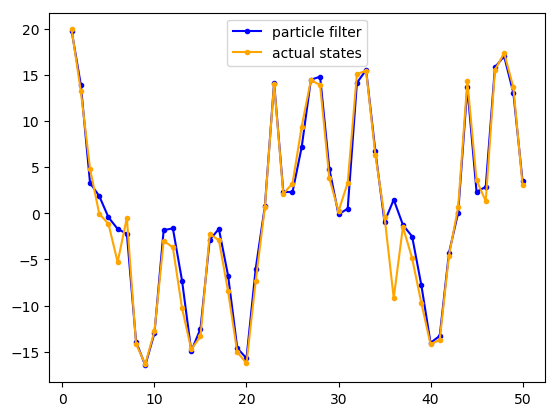

PyObject <matplotlib.legend.Legend object at 0x000000002531D828>

In [6]:
using PyPlot

function simulate(generate_data, particle_filter, N, tt, seed= rand())
    srand(seed)
    data = generate_data(x_0, x_t, y_t, tt)
    x_post = particle_filter(data, x_0, x_t, conditional_likelihoods, N, tt)
    x_expected = mean.(x_post)
    return [x_expected, data[1]]
end

x_pf, x_actual = simulate(generate_data, particle_filter, 300, 50, 1234)
using PyPlot
fig, ax = subplots()
ax[:plot](range(1,50), x_pf, marker = ".",color="blue", label = "particle filter")
ax[:plot](range(1,50), x_actual, marker = ".", color = "orange", label = "actual states")
legend()

We can see that the particle filter approximates the actual states fairly well, although it deviates from the true states in some time points. Different particle filter implementations use different weight calculations for the particles. By choosing a very simplistic proposal distribution in our particle filter, we had to sacrifice accuracy for ease of calculation. 

## Observation Outlier Robust Filtering

Standard Bayesian filtering with the Kalman or Particle filter is not an outlier robust method. To demonstrate this, we will add random asymmetrical outliers to the measurement observations $y_k$.

Recall that the measurement equation is

$$y_k = \frac{x_k^2}{20} + v_k$$

Let $v_k \sim N(0,1)$ with probability $p = 0.9$ and $v_k \sim N(9, .1)$ with probability $q = 0.1$.

In the new *generate_data_with_outliers* function, we will draw from $Binomial(1, 0.1)$ to determine if $y_t$ is an outlier or not. If $y_t$ is an outlier, we will pass $x_t$ through the function *y_t_AO*  instead of *y_t*

In [7]:
function y_t_AO(h_t, x_cur)
    return h_t.(x_cur) + rand(Normal(40, .1), length(x_cur))
end

function generate_data_with_outliers(x_0,  x_t, y_t, y_t_AO, tt)
    xt = fill(0.0, tt)                      # initialize state vector
    yt = fill(0.0, tt)                      # initialize measurement vector
    outliers = fill(0.0, tt)                # initialize outlier vector
    x0 = x_0(1)
    x_pre = x0
    for i in 1:tt
        x_cur = x_t(f_t, x_pre, i, 1)
        xt[i] = x_cur[1]
        if rand(Binomial(1, .1))==1
            yt[i] = y_t_AO(h_t, x_cur)[1]        # y_t is an outlier
            outliers[i] = 1                 # put a 1 in outlier vector
        else
            yt[i] = y_t(h_t, x_cur)[1]           # y_t is not an outlier
        end
        x_pre = x_cur
    end
    return [xt, yt, outliers]
end

generate_data_with_outliers (generic function with 1 method)

Now let's see how the particle filter performs with the outliers. The mean squared error is calculated using the below function:

In [8]:
function mse(estimated, actual)
    return( mean( (estimated-actual).^2 ) )
end

mse (generic function with 1 method)

70

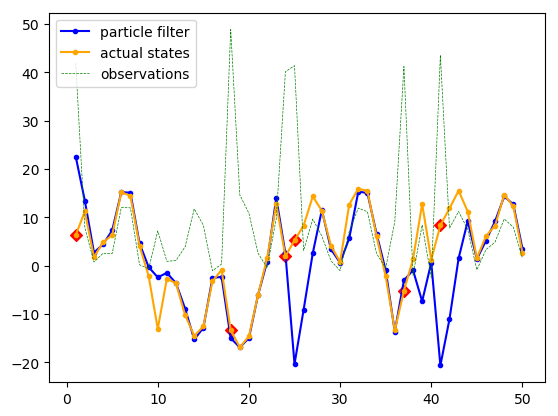

.57223461627285


PyObject <matplotlib.legend.Legend object at 0x0000000025679F28>

In [9]:
srand(4000)
outlier_data = generate_data_with_outliers(x_0, x_t, y_t, y_t_AO, 50)
x_post = particle_filter(outlier_data, x_0, x_t,conditional_likelihoods, 500, 50)
x_expected = mean.(x_post)
println(mse(x_expected, outlier_data[1]))

using PyPlot
fig, ax = subplots()
ax[:plot](range(1,50), x_expected, marker = ".",color="blue", label = "particle filter")
ax[:plot](range(1,50), outlier_data[1], marker = ".", color = "orange", label = "actual states")
ax[:plot](range(1,50), outlier_data[2], "g--", linewidth = 0.5, label = "observations")
for i in 1:50
    if outlier_data[3][i] == 1
        ax[:scatter](i, outlier_data[1][i], marker = "D" ,color = "red")
    end
end
legend()

The red diamonds indicate where the measurement at time $t$ was an outlier. Evidently, the particle filter estimate deviates from the true states in regions where $y_t$ is an outlier.

The mean squared error is **70.57**. Lets see if we can improve this error using two methods to robustify the particle filter, the Maiz Filter (Maiz et al., 2012) and the Robust Filter.

### Maiz Filter

The Maiz filter addresses possible outliers in observed data by incorporating an outlier detection step in the particle filter algorithm.

If $y_t$ is an outlier, we consider it to be "uninformative" and set the filtering density equal to the predictive density:

$$p(x_t|y_{1:t}) = p(x_t|y_{1:t-1})$$

In the particle filter this is equivalent to setting the aposteriori particles equal to their average, $x_t^{(m)} = \bar{x_t}^{(m)}$ for particles $m = 1, ..., M$.

To determine if an observation is an outlier or not, consider a hypothesis test in which

$H_0$: The observation $y_t$ is a sample from $p_t(y_t|y_{1:t-1})$

If the null hypothesis is rejected, then $y_t$ is declared an outlier. Suppose we want to achieve a certain level of significance $\alpha$, the upper bound for the probability of a Type I error. Let $D(y_t, p_t)$ be a nonnegative random variable (a function of $y_t$ and $p_t(y_t|y_{1:t-1})$) and $d_t^\alpha$ be a threshold value such that when $Y_t$ is distributied according to $p_t(y_t|y_{1:t-1})$ then 

$$Pr\{D(y_t, p_t) < d_t^\alpha | y_{1:t-1}\} \leq \alpha$$

The choice of function $D(y_t, p_t)$ is key to the performance of the Maiz filter algorithm since it determines the specific criterion to decide whether an observation is an outlier or not. In this example, we will set $D(y_t, p_t)$ to the predictive density of $y_t$:

$$D(y_t, p_t) = p_t(y_t|y_{1:t-1})$$

As neither $p_t(y_t|y_{1:t-1})$ nor $d_t^\alpha$ can be computed analytically, we use estimates of the two quantities.

To estimate $p_t(y_t|y_{1:t-1})$, we will:
1. First sample from $p(x_t|x_{t-1})$ by propagating each particle to the next state. This is the same step as the particle filter. We call this $x_t^-$
2. Next, sample from $p(y_t|x_t)$ using the measurement equation for each $x_t^-$ that we just sampled.
3. For each particle $i$ in $i = 1, ..., N$, compute the vector $p(y_t^{(i)}|x_t^-)$. Then compute the mean of the vector, $\hat{p}(y_t^{(i)}|x_t^-) = \frac{1}{N}\sum_{i=1}^n p(y_t^{(i)}|x_t^-)$.
4. Then the estimate of $p_t(y_t|y_{1:t-1})$ is $\hat{p}(y_t^{(i)}|y_{1:t-1}) = \frac{1}{N}\sum_{i=1}^N \hat{p}(y_t^{(i)}|x_t^-)$

The threshold $\hat{d}_t^\alpha$ is the $\alpha$-th quantile of the empirical distribution $\hat{p}(y_t^{(i)}|y_{1:t-1})$

The function *likelihood_threshold* computes $\hat{d}_t^\alpha$

In [10]:
function likelihood_threshold(y, x_k_pre, alpha, y_t, conditional_likelihoods)
    y_sample = y_t(h_t, x_k_pre,1)                                      # sample from p(y_t|x_t)
    likelihood_adjustment = fill(0.0, length(y_sample))            # compute threshold
    for i = 1:length(y_sample)
          likelihood_adjustment[i] = mean(conditional_likelihoods(h_t, y_sample[i], x_k_pre, 1))
    end
    d = quantile(likelihood_adjustment, alpha)
    return d
end

likelihood_threshold (generic function with 1 method)

The outlier detection test consists of three steps:
1. Compute the threshold $d_t^\alpha$
2. Compute the statistic $D(y_t, p_t)$
3. If $D(y_t, p_t) < d_t^\alpha$ then declare $y_t$ an outlier. Set the posterior particles *x_k_post* equal to the prior particles *x_k_pre*. If $y_t$ is not an outlier, then proceed with the rest of the particle filter algorithm.


In [11]:
function maiz_filter(data, x_0, x_t, likelihood_threshold, conditional_likelihoods, N, tt)
    x_post = Array{Array{Float64}}(tt)              # initialize x_post
    x = data[1]                                     # states
    y = data[2]                                     # observations
    x_pre = x_0(N)                                                     # Initialization: sample from initial state
    for k = 1:tt
        x_k_pre = x_t(f_t,x_pre, k, 1)                                     # Prediction: sample from p(x_t|x_t-1)
        d = likelihood_threshold(y[k], x_k_pre, 0.05, y_t, conditional_likelihoods)                  # Calculate threshold d
        likelihood = conditional_likelihoods(h_t, y[k], x_k_pre, 1)         # Update: compute weights p(y_k|x_k)
        if (mean(likelihood) < d)      # y is an outlier               # Outlier detection step
            x_k_post = x_k_pre          
            else                       # y is not an outlier
            total = sum(likelihood)                                  
            likelihood = likelihood./total                             # Normalization: normalize weights so that they sum to 1
            x_k_post = wsample(x_k_pre, likelihood, length(x_k_pre))   # Resampling: Draw N new particles
        end
        x_post[k] = x_k_post
        x_pre = x_k_post
    end
    return x_post
end

maiz_filter (generic function with 1 method)

Lets apply the Maiz filter to the previous dataset with outliers.

MSE Classical PF: 70.57223461627285
MSE Maiz Filter: 

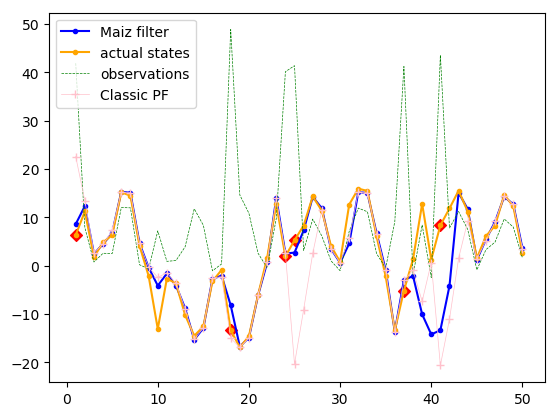

34.183351759676604


PyObject <matplotlib.legend.Legend object at 0x00000000259F39B0>

In [12]:
srand(4000)
outlier_data = generate_data_with_outliers(x_0, x_t, y_t, y_t_AO, 50)
x_post_cl = particle_filter(outlier_data, x_0, x_t,conditional_likelihoods, 500, 50)
x_expected_cl = mean.(x_post_cl)
println("MSE Classical PF: ", mse(x_expected_cl, outlier_data[1]))

x_post = maiz_filter(outlier_data, x_0, x_t,likelihood_threshold, conditional_likelihoods, 500, 50)
x_expected = mean.(x_post)
println("MSE Maiz Filter: ", mse(x_expected, outlier_data[1]))

using PyPlot
fig, ax = subplots()
ax[:plot](range(1,50), x_expected, marker = ".",color="blue", label = "Maiz filter")
ax[:plot](range(1,50), outlier_data[1], marker = ".", color = "orange", label = "actual states")
ax[:plot](range(1,50), outlier_data[2], "g--", linewidth = 0.5, label = "observations")
ax[:plot](range(1,50), x_expected_cl, color="pink", marker="+", linewidth = 0.5, label = "Classic PF")
for i in 1:50
    if outlier_data[3][i] == 1
        ax[:scatter](i, outlier_data[1][i], marker = "D" ,color = "red")
    end
end
legend()

The mean squared error is **34.18**, which is a 55% reduction over the MSE of the original particle filter (**70.57**).

To compare the performance of the two filters above (basic Particle Filter and Maiz Filter), we will apply three types of additive outliers to all filters:

* The "asymmetrical outlier" in which the measurement observation is shifted up by N(9, 0.1)
* The Cauchy outlier in which the measurement observation is shifted by a cauchy distribution with df=1
* The Slash outlier in which the measurement observation is shifted by a slash distribution

We already have the function *y_t_AO* to handle the first case of asymmetrical outliers. The functions *y_t_cauchy* and *y_t_slash* calculate the observations for the other two outlier cases.

In [13]:
function y_t_cauchy(h_t, x_cur)
    return h_t.(x_cur) + rand(TDist(1), length(x_cur))
end

function y_t_slash(h_t, x_cur)
    return h_t.(x_cur) + rand(Normal(0,1))/rand(Uniform(0,1))
end

y_t_slash (generic function with 1 method)

We will modify the *generate_data_with_outliers* function to take in the outlier type as a parameter and calculate the observation accordingly.

In [14]:
function generate_data_with_outliers(x_0, x_t, y_t,y_t_AO, y_t_cauchy, y_t_slash, tt, outlier_type)
    xt = fill(0.0, tt)                      # initialize state vector
    yt = fill(0.0, tt)                      # initialize measurement vector
    outliers = fill(0.0, tt)                # initialize outlier vector
    x0 = x_0(1)
    x_pre = x0
    for i in 1:tt
        x_cur = x_t(f_t, x_pre, i, 1)
        xt[i] = x_cur[1]
        if rand(Binomial(1, .1))==1
            if outlier_type == "asymmetrical"
                yt[i] = y_t_AO(h_t, x_cur)[1]
            elseif outlier_type == "cauchy"
                yt[i] = y_t_cauchy(h_t, x_cur)[1]
            elseif outlier_type == "slash"
                yt[i] = y_t_slash(h_t, x_cur)[1]
            end
            outliers[i] = 1
        else
            yt[i] = y_t(h_t, x_cur, 1)[1]
        end
        x_pre = x_cur
    end
    return [xt,yt, outliers]
end

generate_data_with_outliers (generic function with 2 methods)

In [15]:
function simulate_all_clean(generate_data, particle_filter, maiz_filter, mse, N, tt, simulations)
    mse_pf = fill(0.0, simulations)
    mse_maiz = fill(0.0, simulations)
    for s in 1:simulations
        clean_data = generate_data(x_0, x_t, y_t, tt)
        pf = mean.(particle_filter(clean_data, x_0, x_t, conditional_likelihoods, N, tt))
        maiz = mean.(maiz_filter(clean_data, x_0, x_t, likelihood_threshold, conditional_likelihoods, N, tt))
        mse_pf[s] = mse(pf, clean_data[1])
        mse_maiz[s] = mse(maiz, clean_data[1])
    end
    return [mse_pf, mse_maiz]
end

function simulate_all_outlier(generate_data_with_outliers, outlier_type, particle_filter, maiz_filter, mse, N,tt, simulations)
    mse_pf = fill(0.0, simulations)
    mse_maiz = fill(0.0, simulations)
    for s in 1:simulations
        outlier_data = generate_data_with_outliers(x_0, x_t, y_t,y_t_AO, y_t_cauchy, y_t_slash, tt, outlier_type)
        pf = mean.(particle_filter(outlier_data, x_0, x_t, conditional_likelihoods, N, tt))
        maiz = mean.(maiz_filter(outlier_data, x_0, x_t, likelihood_threshold, conditional_likelihoods, N, tt))
        mse_pf[s] = mse(pf, outlier_data[1])
        mse_maiz[s] = mse(maiz, outlier_data[1])
    end
    return [mse_pf, mse_maiz]
end

simulate_all_outlier (generic function with 1 method)

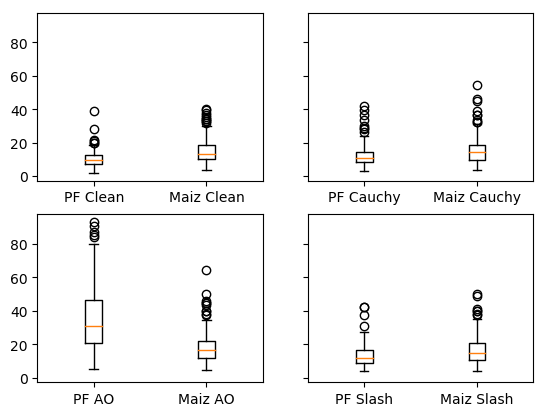

Dict{Any,Any} with 6 entries:
  "means"    => Any[]
  "whiskers" => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x0…
  "fliers"   => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x0…
  "boxes"    => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x0…
  "caps"     => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x0…
  "medians"  => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x0…

In [16]:
mse_pf_AO, mse_maiz_AO = simulate_all_outlier(generate_data_with_outliers,"asymmetrical", particle_filter, maiz_filter, mse, 500, 100, 200)
mse_pf_cauchy, mse_maiz_cauchy = simulate_all_outlier(generate_data_with_outliers,"cauchy", particle_filter, maiz_filter, mse, 500, 100, 200)
mse_pf_slash, mse_maiz_slash = simulate_all_outlier(generate_data_with_outliers,"slash", particle_filter, maiz_filter, mse, 500, 100, 200)
mse_pf_clean, mse_maiz_clean = simulate_all_clean(generate_data, particle_filter, maiz_filter, mse, 500, 100, 200)

using PyPlot
f, (ax1, ax2, ax3, ax4) = subplots(2, 2, sharey=true)
ax1[:boxplot]([mse_pf_clean, mse_maiz_clean], labels = ["PF Clean", "Maiz Clean"])
ax2[:boxplot]([mse_pf_AO, mse_maiz_AO], labels = ["PF AO", "Maiz AO"])
ax3[:boxplot]([mse_pf_cauchy, mse_maiz_cauchy], labels = ["PF Cauchy", "Maiz Cauchy"])
ax4[:boxplot]([mse_pf_slash, mse_maiz_slash], labels = ["PF Slash", "Maiz Slash"])

#### References

- Simon, D (2006). Optimal State Estimation. Hoboken: John Wiley & Sons. 
- Arulampalam, M.S., Maskell, S., Gordon, N. and Clapp, T. (2002). A Tutorial on Particle Filters for Online Nonlinear/Non-Gaussian Bayesian Tracking. IEEE Transactions on Signal Processing 50(2): 174-188. 
- Doucet, A. and Johansen, A.M. (2008). A Tutorial on Particle Filtering and Smoothing: Fifteen Years Later. Available at http://www.cs.ubc.ca/~arnaud/doucet_johansen_tutorialPF.pdf
- Ghahramani, Z. (2001). An Introduction to Hidden Markov Models and Bayesian Networks. International Journal of Pattern Recognition and Artificial Intelligence 15(1): 9-42.
- Orlande, H.R.B. et al. (2013). Kalman and Particle Filters. Available at http://www.sft.asso.fr/Local/sft/dir/user-3775/documents/actes/Metti5_School/Lectures&Tutorials-Texts/Text-T10-Orlande.pdf
- Minor, B. (2011). Particle Filters. Available at http://www.eecs.wsu.edu/~cook/ml/presentations/bryan.pdf
- Abbeel, P. (2012). Particle Filters. Available at https://people.eecs.berkeley.edu/~pabbeel/cs287-fa12/slides/ParticleFilters.pdf
- Kozierski P., Lis M. and Ziętkiewicz J. (2013). Resampling in Particle Filtering - Comparison. Studia z Automatyki i Informatyki 38: 35-64.
- Maíz, C.S., Molanes-López, E.M., Míguez, J. and Djuriü, P.M. (2012). A particle fltering scheme for processing time series corrupted by outliers. IEEE Transactions on Signal Processing 60(9): 4611-4627